In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# sklearn.set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
flight_data_train = pd.read_csv('./flight_data_train_ohe.csv')
flight_data_test = pd.read_csv('./flight_data_test_ohe.csv')

In [3]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

In [4]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
# flight_data_train['depart_year'] = departdatetime.year
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
# flight_data_test['depart_year'] = departdatetime.year
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [5]:
X_train = flight_data_train.drop(columns=['finalflightstatus', 'delay_in_secs', 'publicgatenumber', 'destination_iata'], axis=1)
X_test = flight_data_test.drop(columns=['finalflightstatus', 'delay_in_secs', 'publicgatenumber', 'destination_iata'], axis=1)

y_train_cls = flight_data_train['finalflightstatus']
y_test_cls = flight_data_test['finalflightstatus']
y_train_reg = flight_data_train['delay_in_secs']
y_test_reg = flight_data_test['delay_in_secs']

In [6]:
y_train_cls = y_train_cls.map({'On-Time': 0, 'Delayed':1})
y_test_cls = y_test_cls.map({'On-Time': 0, 'Delayed':1})

In [13]:
X_train

,isconnecting,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_BKN,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_BKN,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PC,traffictypecode_PE,traffictypecode_PS,aircraftterminal_0,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,airlinecode_iata_0B,airlinecode_iata_3Z,airlinecode_iata_4R,airlinecode_iata_5J,airlinecode_iata_5Q,airlinecode_iata_6E,airlinecode_iata_6H,airlinecode_iata_6Y,airlinecode_iata_7W,airlinecode_iata_8M,airlinecode_iata_A2,airlinecode_iata_A4,airlinecode_iata_A9,airlinecode_iata_AC,airlinecode_iata_AF,airlinecode_iata_AH,airlinecode_iata_AI,airlinecode_iata_AT,airlinecode_iata_AY,airlinecode_iata_B2,airlinecode_iata_B9,airlinecode_iata_BA,airlinecode_iata_BG,airlinecode_iata_BI,airlinecode_iata_BS,airlinecode_iata_BT,airlinecode_iata_BV,airlinecode_iata_BY,airlinecode_iata_CA,airlinecode_iata_CX,airlinecode_iata_CZ,airlinecode_iata_D3,airlinecode_iata_DE,airlinecode_iata_DP,airlinecode_iata_DY,airlinecode_iata_E4,airlinecode_iata_EB,airlinecode_iata_EK,airlinecode_iata_EO,airlinecode_iata_ER,airlinecode_iata_ET,airlinecode_iata_EY,airlinecode_iata_F3,airlinecode_iata_F6,airlinecode_iata_F7,airlinecode_iata_FB,airlinecode_iata_FG,airlinecode_iata_FH,airlinecode_iata_FO,airlinecode_iata_FV,airlinecode_iata_FZ,airlinecode_iata_G8,airlinecode_iata_G9,airlinecode_iata_GA,airlinecode_iata_GF,airlinecode_iata_GW,airlinecode_iata_H4,airlinecode_iata_H9,airlinecode_iata_HH,airlinecode_iata_HM,airlinecode_iata_HU,airlinecode_iata_HV,airlinecode_iata_HY,airlinecode_iata_IA,airlinecode_iata_IB,airlinecode_iata_IF,airlinecode_iata_IR,airlinecode_iata_IX,airlinecode_iata_IY,airlinecode_iata_IZ,airlinecode_iata_J2,airlinecode_iata_J4,airlinecode_iata_J9,airlinecode_iata_JU,airlinecode_iata_KC,airlinecode_iata_KL,airlinecode_iata_KQ,airlinecode_iata_KU,airlinecode_iata_LG,airlinecode_iata_LH,airlinecode_iata_LO,airlinecode_iata_LX,airlinecode_iata_LY,airlinecode_iata_ME,airlinecode_iata_MH,airlinecode_iata_MJ,airlinecode_iata_MS,airlinecode_iata_N4,airlinecode_iata_NO,airlinecode_iata_OM,airlinecode_iata_OR,airlinecode_iata_OV,airlinecode_iata_P4,airlinecode_iata_P6,airlinecode_iata_PA,airlinecode_iata_PC,airlinecode_iata_PF,airlinecode_iata_PK,airlinecode_iata_PQ,airlinecode_iata_PR,airlinecode_iata_PS,airlinecode_iata_QB,airlinecode_iata_QF,airlinecode_iata_QH,airlinecode_iata_QR,airlinecode_iata_QS,airlinecode_iata_QU,airlinecode_iata_R5,airlinecode_iata_RA,airlinecode_iata_RB,airlinecode_iata_RJ,airlinecode_iata_RL,airlinecode_iata_RQ,airlinecode_iata_S7,airlinecode_iata_SG,airlinecode_iata_SM,airlinecode_iata_SQ,airlinecode_iata_SS,airlinecode_iata_SU,airlinecode_iata_SV,airlinecode_iata_SZ,airlinecode_iata_T5,airlinecode_iata_TG,airlinecode_iata_TK,airlinecode_iata_U6,airlinecode_iata_U8,airlinecode_iata_UB,airlinecode_iata_UD,airlinecode_iata_UK,airlinecode_iata_UL,airlinecode_iata_UR,airlinecode_iata_UT,airlinecode_iata_VJ,airlinecode_iata_VN,airlinecode_iata_VS,airlinecode_iata_W5,airlinecode_iata_W6,airlinecode_iata_WB,airlinecode_iata_WY,airlinecode_iata_X3,airlinecode_iata_X9,airlinecode_iata_XQ,airlinecode_iata_XY,airlinecode_iata_Y9,airlinecode_iata_YU,airlinecode_iata_ZF,airlinecode_iata_ZT,aircraft_iata_223,aircraft_iata_295,aircraft_iata_312,aircraft_iata_313,aircraft_iata_319,aircraft_iata_320,aircraft_iata_321,aircraft_iata_32A,aircraft_iata_32B,aircraft_iata_32N,aircraft_iata_32Q,aircraft_iata_332,aircraft_iata_333,aircraft_iata_338,aircraft_iata_339,aircraft_iata_343,aircraft_iata_345,aircraft_iata_346,aircraft_iata_351,aircraft_iata_359,aircraft_iata_388,aircraft_iata_733,aircraft_iata_734,aircraft_iata_735,aircraft_iata_737,aircraft_iata_738,aircraft_iata_739,aircraft_iata_73E,aircraft_iata_73H,aircraft_iata_73J,aircraft_iata_73W,aircraft_iata_744,aircraft_iata_74H,aircraft_iata_752,aircraft_iata_75T,aircraft_iata_75W,aircraft_iata_762,aircraft_iat

In [8]:
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 14, 15])
print('Original dataset shape %s' % Counter(y_train_cls))
X_train, y_train_cls = smote.fit_resample(X_train, y_train_cls)
print('Resampled dataset shape %s' % Counter(y_train_cls))


Original dataset shape Counter({0: 111128, 1: 41512})
Resampled dataset shape Counter({0: 111128, 1: 111128})


In [11]:
X_train

,isconnecting,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_BKN,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_BKN,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PC,traffictypecode_PE,traffictypecode_PS,aircraftterminal_0,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,airlinecode_iata_0B,airlinecode_iata_3Z,airlinecode_iata_4R,airlinecode_iata_5J,airlinecode_iata_5Q,airlinecode_iata_6E,airlinecode_iata_6H,airlinecode_iata_6Y,airlinecode_iata_7W,airlinecode_iata_8M,airlinecode_iata_A2,airlinecode_iata_A4,airlinecode_iata_A9,airlinecode_iata_AC,airlinecode_iata_AF,airlinecode_iata_AH,airlinecode_iata_AI,airlinecode_iata_AT,airlinecode_iata_AY,airlinecode_iata_B2,airlinecode_iata_B9,airlinecode_iata_BA,airlinecode_iata_BG,airlinecode_iata_BI,airlinecode_iata_BS,airlinecode_iata_BT,airlinecode_iata_BV,airlinecode_iata_BY,airlinecode_iata_CA,airlinecode_iata_CX,airlinecode_iata_CZ,airlinecode_iata_D3,airlinecode_iata_DE,airlinecode_iata_DP,airlinecode_iata_DY,airlinecode_iata_E4,airlinecode_iata_EB,airlinecode_iata_EK,airlinecode_iata_EO,airlinecode_iata_ER,airlinecode_iata_ET,airlinecode_iata_EY,airlinecode_iata_F3,airlinecode_iata_F6,airlinecode_iata_F7,airlinecode_iata_FB,airlinecode_iata_FG,airlinecode_iata_FH,airlinecode_iata_FO,airlinecode_iata_FV,airlinecode_iata_FZ,airlinecode_iata_G8,airlinecode_iata_G9,airlinecode_iata_GA,airlinecode_iata_GF,airlinecode_iata_GW,airlinecode_iata_H4,airlinecode_iata_H9,airlinecode_iata_HH,airlinecode_iata_HM,airlinecode_iata_HU,airlinecode_iata_HV,airlinecode_iata_HY,airlinecode_iata_IA,airlinecode_iata_IB,airlinecode_iata_IF,airlinecode_iata_IR,airlinecode_iata_IX,airlinecode_iata_IY,airlinecode_iata_IZ,airlinecode_iata_J2,airlinecode_iata_J4,airlinecode_iata_J9,airlinecode_iata_JU,airlinecode_iata_KC,airlinecode_iata_KL,airlinecode_iata_KQ,airlinecode_iata_KU,airlinecode_iata_LG,airlinecode_iata_LH,airlinecode_iata_LO,airlinecode_iata_LX,airlinecode_iata_LY,airlinecode_iata_ME,airlinecode_iata_MH,airlinecode_iata_MJ,airlinecode_iata_MS,airlinecode_iata_N4,airlinecode_iata_NO,airlinecode_iata_OM,airlinecode_iata_OR,airlinecode_iata_OV,airlinecode_iata_P4,airlinecode_iata_P6,airlinecode_iata_PA,airlinecode_iata_PC,airlinecode_iata_PF,airlinecode_iata_PK,airlinecode_iata_PQ,airlinecode_iata_PR,airlinecode_iata_PS,airlinecode_iata_QB,airlinecode_iata_QF,airlinecode_iata_QH,airlinecode_iata_QR,airlinecode_iata_QS,airlinecode_iata_QU,airlinecode_iata_R5,airlinecode_iata_RA,airlinecode_iata_RB,airlinecode_iata_RJ,airlinecode_iata_RL,airlinecode_iata_RQ,airlinecode_iata_S7,airlinecode_iata_SG,airlinecode_iata_SM,airlinecode_iata_SQ,airlinecode_iata_SS,airlinecode_iata_SU,airlinecode_iata_SV,airlinecode_iata_SZ,airlinecode_iata_T5,airlinecode_iata_TG,airlinecode_iata_TK,airlinecode_iata_U6,airlinecode_iata_U8,airlinecode_iata_UB,airlinecode_iata_UD,airlinecode_iata_UK,airlinecode_iata_UL,airlinecode_iata_UR,airlinecode_iata_UT,airlinecode_iata_VJ,airlinecode_iata_VN,airlinecode_iata_VS,airlinecode_iata_W5,airlinecode_iata_W6,airlinecode_iata_WB,airlinecode_iata_WY,airlinecode_iata_X3,airlinecode_iata_X9,airlinecode_iata_XQ,airlinecode_iata_XY,airlinecode_iata_Y9,airlinecode_iata_YU,airlinecode_iata_ZF,airlinecode_iata_ZT,aircraft_iata_223,aircraft_iata_295,aircraft_iata_312,aircraft_iata_313,aircraft_iata_319,aircraft_iata_320,aircraft_iata_321,aircraft_iata_32A,aircraft_iata_32B,aircraft_iata_32N,aircraft_iata_32Q,aircraft_iata_332,aircraft_iata_333,aircraft_iata_338,aircraft_iata_339,aircraft_iata_343,aircraft_iata_345,aircraft_iata_346,aircraft_iata_351,aircraft_iata_359,aircraft_iata_388,aircraft_iata_733,aircraft_iata_734,aircraft_iata_735,aircraft_iata_737,aircraft_iata_738,aircraft_iata_739,aircraft_iata_73E,aircraft_iata_73H,aircraft_iata_73J,aircraft_iata_73W,aircraft_iata_744,aircraft_iata_74H,aircraft_iata_752,aircraft_iata_75T,aircraft_iata_75W,aircraft_iata_762,aircraft_iat

In [12]:
one_hot_column = [
    "skyc1",
    "skyc2",
    "traffictypecode",
    "aircraftterminal",
    "airlinecode_iata",
    # "destination_iata",
    "aircraft_iata",
]  # , 'publicgatenumber']

ohe = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='infrequent_if_exist')

encoded = ohe.fit_transform(X_train[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)

KeyError: "None of [Index(['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal',\n       'airlinecode_iata', 'aircraft_iata'],\n      dtype='object')] are in the [columns]"

In [14]:
X_train

,isconnecting,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_BKN,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_BKN,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PC,traffictypecode_PE,traffictypecode_PS,aircraftterminal_0,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,airlinecode_iata_0B,airlinecode_iata_3Z,airlinecode_iata_4R,airlinecode_iata_5J,airlinecode_iata_5Q,airlinecode_iata_6E,airlinecode_iata_6H,airlinecode_iata_6Y,airlinecode_iata_7W,airlinecode_iata_8M,airlinecode_iata_A2,airlinecode_iata_A4,airlinecode_iata_A9,airlinecode_iata_AC,airlinecode_iata_AF,airlinecode_iata_AH,airlinecode_iata_AI,airlinecode_iata_AT,airlinecode_iata_AY,airlinecode_iata_B2,airlinecode_iata_B9,airlinecode_iata_BA,airlinecode_iata_BG,airlinecode_iata_BI,airlinecode_iata_BS,airlinecode_iata_BT,airlinecode_iata_BV,airlinecode_iata_BY,airlinecode_iata_CA,airlinecode_iata_CX,airlinecode_iata_CZ,airlinecode_iata_D3,airlinecode_iata_DE,airlinecode_iata_DP,airlinecode_iata_DY,airlinecode_iata_E4,airlinecode_iata_EB,airlinecode_iata_EK,airlinecode_iata_EO,airlinecode_iata_ER,airlinecode_iata_ET,airlinecode_iata_EY,airlinecode_iata_F3,airlinecode_iata_F6,airlinecode_iata_F7,airlinecode_iata_FB,airlinecode_iata_FG,airlinecode_iata_FH,airlinecode_iata_FO,airlinecode_iata_FV,airlinecode_iata_FZ,airlinecode_iata_G8,airlinecode_iata_G9,airlinecode_iata_GA,airlinecode_iata_GF,airlinecode_iata_GW,airlinecode_iata_H4,airlinecode_iata_H9,airlinecode_iata_HH,airlinecode_iata_HM,airlinecode_iata_HU,airlinecode_iata_HV,airlinecode_iata_HY,airlinecode_iata_IA,airlinecode_iata_IB,airlinecode_iata_IF,airlinecode_iata_IR,airlinecode_iata_IX,airlinecode_iata_IY,airlinecode_iata_IZ,airlinecode_iata_J2,airlinecode_iata_J4,airlinecode_iata_J9,airlinecode_iata_JU,airlinecode_iata_KC,airlinecode_iata_KL,airlinecode_iata_KQ,airlinecode_iata_KU,airlinecode_iata_LG,airlinecode_iata_LH,airlinecode_iata_LO,airlinecode_iata_LX,airlinecode_iata_LY,airlinecode_iata_ME,airlinecode_iata_MH,airlinecode_iata_MJ,airlinecode_iata_MS,airlinecode_iata_N4,airlinecode_iata_NO,airlinecode_iata_OM,airlinecode_iata_OR,airlinecode_iata_OV,airlinecode_iata_P4,airlinecode_iata_P6,airlinecode_iata_PA,airlinecode_iata_PC,airlinecode_iata_PF,airlinecode_iata_PK,airlinecode_iata_PQ,airlinecode_iata_PR,airlinecode_iata_PS,airlinecode_iata_QB,airlinecode_iata_QF,airlinecode_iata_QH,airlinecode_iata_QR,airlinecode_iata_QS,airlinecode_iata_QU,airlinecode_iata_R5,airlinecode_iata_RA,airlinecode_iata_RB,airlinecode_iata_RJ,airlinecode_iata_RL,airlinecode_iata_RQ,airlinecode_iata_S7,airlinecode_iata_SG,airlinecode_iata_SM,airlinecode_iata_SQ,airlinecode_iata_SS,airlinecode_iata_SU,airlinecode_iata_SV,airlinecode_iata_SZ,airlinecode_iata_T5,airlinecode_iata_TG,airlinecode_iata_TK,airlinecode_iata_U6,airlinecode_iata_U8,airlinecode_iata_UB,airlinecode_iata_UD,airlinecode_iata_UK,airlinecode_iata_UL,airlinecode_iata_UR,airlinecode_iata_UT,airlinecode_iata_VJ,airlinecode_iata_VN,airlinecode_iata_VS,airlinecode_iata_W5,airlinecode_iata_W6,airlinecode_iata_WB,airlinecode_iata_WY,airlinecode_iata_X3,airlinecode_iata_X9,airlinecode_iata_XQ,airlinecode_iata_XY,airlinecode_iata_Y9,airlinecode_iata_YU,airlinecode_iata_ZF,airlinecode_iata_ZT,aircraft_iata_223,aircraft_iata_295,aircraft_iata_312,aircraft_iata_313,aircraft_iata_319,aircraft_iata_320,aircraft_iata_321,aircraft_iata_32A,aircraft_iata_32B,aircraft_iata_32N,aircraft_iata_32Q,aircraft_iata_332,aircraft_iata_333,aircraft_iata_338,aircraft_iata_339,aircraft_iata_343,aircraft_iata_345,aircraft_iata_346,aircraft_iata_351,aircraft_iata_359,aircraft_iata_388,aircraft_iata_733,aircraft_iata_734,aircraft_iata_735,aircraft_iata_737,aircraft_iata_738,aircraft_iata_739,aircraft_iata_73E,aircraft_iata_73H,aircraft_iata_73J,aircraft_iata_73W,aircraft_iata_744,aircraft_iata_74H,aircraft_iata_752,aircraft_iata_75T,aircraft_iata_75W,aircraft_iata_762,aircraft_iat

In [15]:
numerical_cols = [
    "tmpf",
    "dwpf",
    "relh",
    "drct",
    "sknt",
    "p01i",
    "alti",
    "vsby",
    "skyl1",
    "skyl2",
    # 'depart_day',
    # 'depart_month',
    # 'depart_minute'
]

In [13]:
# scaler = StandardScaler()
# X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [17]:
X_train

,isconnecting,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_BKN,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_BKN,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PC,traffictypecode_PE,traffictypecode_PS,aircraftterminal_0,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,airlinecode_iata_0B,airlinecode_iata_3Z,airlinecode_iata_4R,airlinecode_iata_5J,airlinecode_iata_5Q,airlinecode_iata_6E,airlinecode_iata_6H,airlinecode_iata_6Y,airlinecode_iata_7W,airlinecode_iata_8M,airlinecode_iata_A2,airlinecode_iata_A4,airlinecode_iata_A9,airlinecode_iata_AC,airlinecode_iata_AF,airlinecode_iata_AH,airlinecode_iata_AI,airlinecode_iata_AT,airlinecode_iata_AY,airlinecode_iata_B2,airlinecode_iata_B9,airlinecode_iata_BA,airlinecode_iata_BG,airlinecode_iata_BI,airlinecode_iata_BS,airlinecode_iata_BT,airlinecode_iata_BV,airlinecode_iata_BY,airlinecode_iata_CA,airlinecode_iata_CX,airlinecode_iata_CZ,airlinecode_iata_D3,airlinecode_iata_DE,airlinecode_iata_DP,airlinecode_iata_DY,airlinecode_iata_E4,airlinecode_iata_EB,airlinecode_iata_EK,airlinecode_iata_EO,airlinecode_iata_ER,airlinecode_iata_ET,airlinecode_iata_EY,airlinecode_iata_F3,airlinecode_iata_F6,airlinecode_iata_F7,airlinecode_iata_FB,airlinecode_iata_FG,airlinecode_iata_FH,airlinecode_iata_FO,airlinecode_iata_FV,airlinecode_iata_FZ,airlinecode_iata_G8,airlinecode_iata_G9,airlinecode_iata_GA,airlinecode_iata_GF,airlinecode_iata_GW,airlinecode_iata_H4,airlinecode_iata_H9,airlinecode_iata_HH,airlinecode_iata_HM,airlinecode_iata_HU,airlinecode_iata_HV,airlinecode_iata_HY,airlinecode_iata_IA,airlinecode_iata_IB,airlinecode_iata_IF,airlinecode_iata_IR,airlinecode_iata_IX,airlinecode_iata_IY,airlinecode_iata_IZ,airlinecode_iata_J2,airlinecode_iata_J4,airlinecode_iata_J9,airlinecode_iata_JU,airlinecode_iata_KC,airlinecode_iata_KL,airlinecode_iata_KQ,airlinecode_iata_KU,airlinecode_iata_LG,airlinecode_iata_LH,airlinecode_iata_LO,airlinecode_iata_LX,airlinecode_iata_LY,airlinecode_iata_ME,airlinecode_iata_MH,airlinecode_iata_MJ,airlinecode_iata_MS,airlinecode_iata_N4,airlinecode_iata_NO,airlinecode_iata_OM,airlinecode_iata_OR,airlinecode_iata_OV,airlinecode_iata_P4,airlinecode_iata_P6,airlinecode_iata_PA,airlinecode_iata_PC,airlinecode_iata_PF,airlinecode_iata_PK,airlinecode_iata_PQ,airlinecode_iata_PR,airlinecode_iata_PS,airlinecode_iata_QB,airlinecode_iata_QF,airlinecode_iata_QH,airlinecode_iata_QR,airlinecode_iata_QS,airlinecode_iata_QU,airlinecode_iata_R5,airlinecode_iata_RA,airlinecode_iata_RB,airlinecode_iata_RJ,airlinecode_iata_RL,airlinecode_iata_RQ,airlinecode_iata_S7,airlinecode_iata_SG,airlinecode_iata_SM,airlinecode_iata_SQ,airlinecode_iata_SS,airlinecode_iata_SU,airlinecode_iata_SV,airlinecode_iata_SZ,airlinecode_iata_T5,airlinecode_iata_TG,airlinecode_iata_TK,airlinecode_iata_U6,airlinecode_iata_U8,airlinecode_iata_UB,airlinecode_iata_UD,airlinecode_iata_UK,airlinecode_iata_UL,airlinecode_iata_UR,airlinecode_iata_UT,airlinecode_iata_VJ,airlinecode_iata_VN,airlinecode_iata_VS,airlinecode_iata_W5,airlinecode_iata_W6,airlinecode_iata_WB,airlinecode_iata_WY,airlinecode_iata_X3,airlinecode_iata_X9,airlinecode_iata_XQ,airlinecode_iata_XY,airlinecode_iata_Y9,airlinecode_iata_YU,airlinecode_iata_ZF,airlinecode_iata_ZT,aircraft_iata_223,aircraft_iata_295,aircraft_iata_312,aircraft_iata_313,aircraft_iata_319,aircraft_iata_320,aircraft_iata_321,aircraft_iata_32A,aircraft_iata_32B,aircraft_iata_32N,aircraft_iata_32Q,aircraft_iata_332,aircraft_iata_333,aircraft_iata_338,aircraft_iata_339,aircraft_iata_343,aircraft_iata_345,aircraft_iata_346,aircraft_iata_351,aircraft_iata_359,aircraft_iata_388,aircraft_iata_733,aircraft_iata_734,aircraft_iata_735,aircraft_iata_737,aircraft_iata_738,aircraft_iata_739,aircraft_iata_73E,aircraft_iata_73H,aircraft_iata_73J,aircraft_iata_73W,aircraft_iata_744,aircraft_iata_74H,aircraft_iata_752,aircraft_iata_75T,aircraft_iata_75W,aircraft_iata_762,aircraft_iat

In [18]:
# Create cyclic features for month and day
X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# Drop original cyclic features
X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


In [19]:
from scipy.stats import f_oneway

# Assuming y_train_cls is your target variable
anova_results = {}
for column in X_train.columns:
    # Perform ANOVA
    f_val, p_val = f_oneway(X_train[column], y_train_cls)
    anova_results[column] = f_val

# Sort the results by F-value
sorted_anova = sorted(anova_results.items(), key=lambda x: x[1], reverse=True)

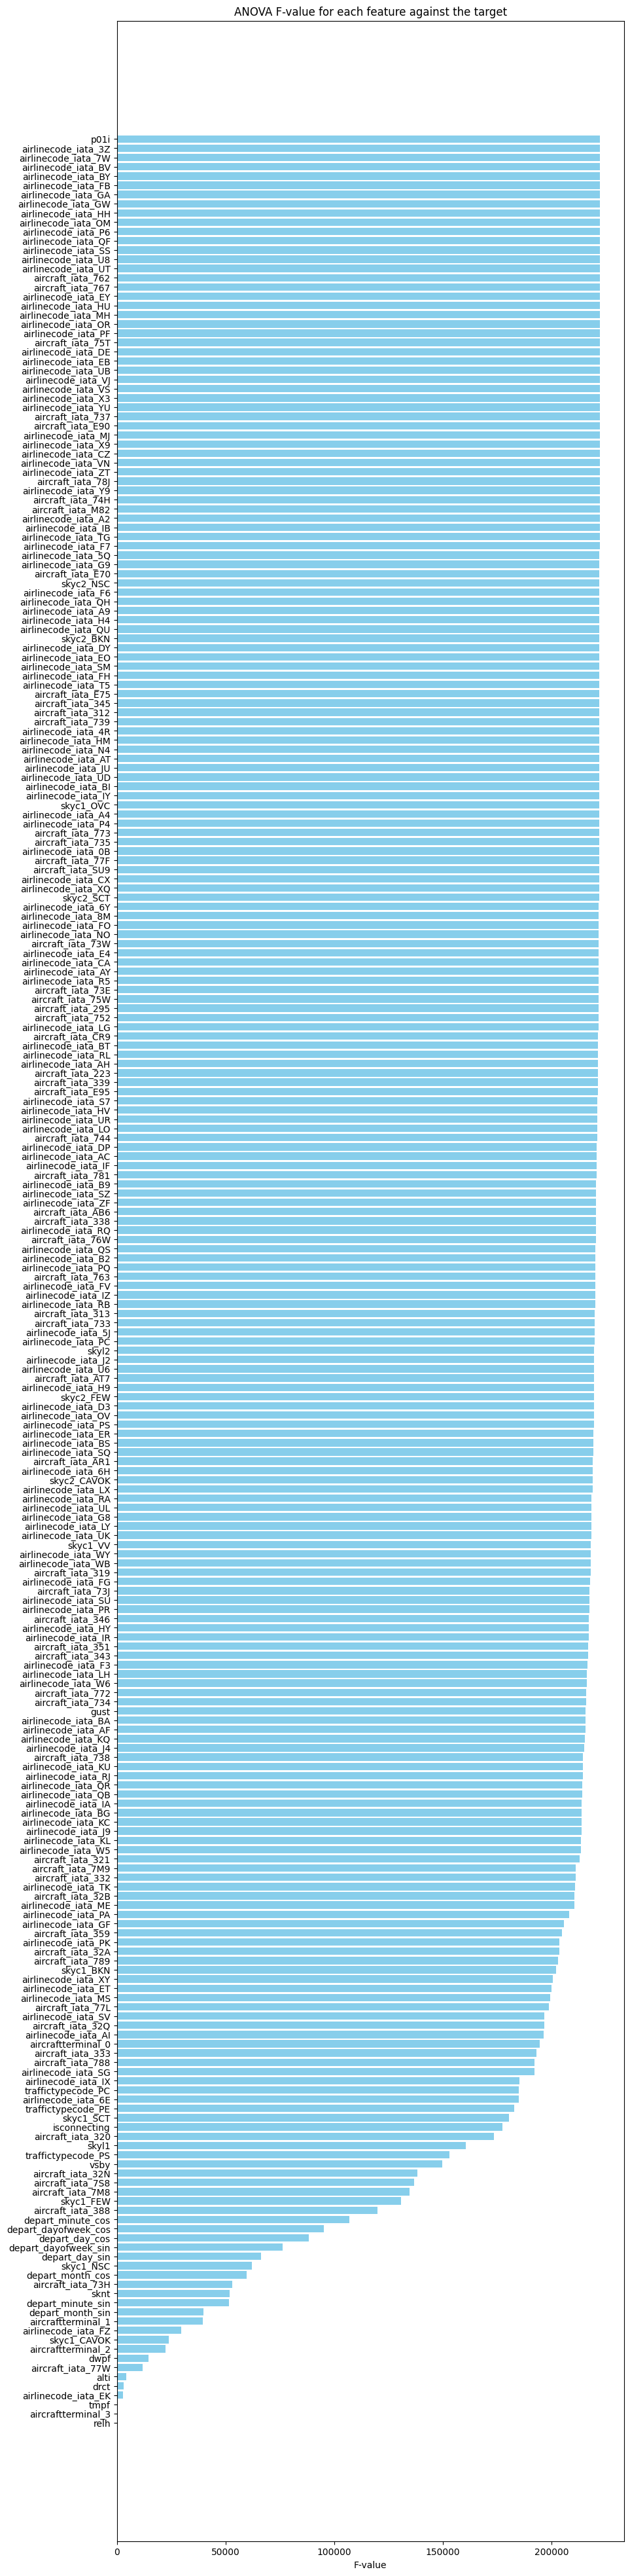

In [20]:
# Plotting
plt.figure(figsize=(10, 50))
plt.barh([x[0] for x in sorted_anova], [x[1] for x in sorted_anova], color='skyblue')
plt.xlabel('F-value')
plt.title('ANOVA F-value for each feature against the target')
plt.gca().invert_yaxis()
plt.show()

In [19]:
# X_full = pd.concat([X_train, X_test], axis=0)
# X_full

In [20]:
# neighbors = NearestNeighbors(n_neighbors=39*2)
# neighbors_fit = neighbors.fit(X_train)
# distances, indices = neighbors_fit.kneighbors(X_train)
# avg_distance = distances.mean(axis=1)
# plt.plot(np.sort(avg_distance))
# plt.show()

In [21]:
# sc = DBSCAN(eps=1, min_samples=39*2, algorithm='kd_tree')
# clusters = pd.DataFrame(sc.fit_predict(X_full), columns=['Cluster'])
# clusters['Cluster'].value_counts()

: 

In [21]:
hdbscan_model = HDBSCAN(
    min_cluster_size=1000,      # Increase to avoid microclusters
    min_samples=5,              # Lower to reduce noise points
    cluster_selection_epsilon=0.6,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()

In [30]:
from hdbscan import approximate_predict
clusters_test, _ = approximate_predict(hdbscan_model, X_test)

In [31]:
X_train['cluster'] = clusters_train['Cluster']
X_test['cluster'] = clusters_test

In [33]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

rf_models = {}
metrics = {}
all_y_true = []
all_y_pred = []
model_weights = {}

for cluster in np.unique(clusters_train):
    if cluster == -1:  # Ignore noise points (label -1)
        continue

    # Subset the training and test data for the cluster
    # Get cluster data
    X_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_cls_cluster = y_train_cls.loc[X_cluster.index]
    
    # Split into train and validation sets
    X_train_cluster, X_val_cluster, y_train_cls_cluster, y_val_cls_cluster = train_test_split(
        X_cluster, y_cls_cluster, test_size=0.2, random_state=42
    )
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cls_cluster = y_test_cls.loc[X_test_cluster.index]
    
    # Clean data - remove rows with NaN or infinite values
    mask_train = ~(np.isnan(X_train_cluster).any(axis=1) | np.isinf(X_train_cluster).any(axis=1))
    mask_test = ~(np.isnan(X_test_cluster).any(axis=1) | np.isinf(X_test_cluster).any(axis=1))
    
    X_train_cluster = X_train_cluster[mask_train]
    y_train_cls_cluster = y_train_cls_cluster[mask_train]
    X_test_cluster = X_test_cluster[mask_test]
    y_test_cls_cluster = y_test_cls_cluster[mask_test]

    # Define objective function for hyperopt
    param_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy', 'log_loss'])
    }

    # Use Bayesian optimization for hyperparameter tuning
    bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=param_space,
        n_iter=50,
        cv=3,
        n_jobs=-1,
        scoring='f1'
    )
    bayes_cv.fit(X_train_cluster, y_train_cls_cluster)
    best_rf = bayes_cv.best_estimator_
    rf_models[cluster] = best_rf

    # Make predictions on the validation set and evaluate metrics
    y_val_pred = best_rf.predict(X_val_cluster)
    accuracy = accuracy_score(y_val_cls_cluster, y_val_pred)
    precision = precision_score(y_val_cls_cluster, y_val_pred)
    recall = recall_score(y_val_cls_cluster, y_val_pred)
    f1 = f1_score(y_val_cls_cluster, y_val_pred)
    model_weights[cluster] = f1  # Assign weight to the model based on validation F1 score

    # Print metrics
    print(f"Cluster {cluster} Validation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 0 Validation Metrics:
Accuracy: 0.7858851674641149
Precision: 0.7766599597585513
Recall: 0.8502202643171806
F1 Score: 0.8117770767613038
Cluster 1 Validation Metrics:
Accuracy: 0.8363636363636363
Precision: 0.8878504672897196
Recall: 0.7421875
F1 Score: 0.8085106382978723
Cluster 2 Validation Metrics:
Accuracy: 0.7743362831858407
Precision: 0.7319587628865979
Recall: 0.7395833333333334
F1 Score: 0.7357512953367875
Cluster 3 Validation Metrics:
Accuracy: 0.852112676056338
Precision: 0.8241758241758241
Recall: 0.9375
F1 Score: 0.8771929824561403
Cluster 4 Validation Metrics:
Accuracy: 0.8260201229737283
Precision: 0.8327586206896552
Recall: 0.8138163437236732
F1 Score: 0.8231785257775884
Cluster 5 Validation Metrics:
Accuracy: 0.74235807860262
Precision: 0.7767857142857143
Recall: 0.71900826446281
F1 Score: 0.7467811158798283


/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 6 Validation Metrics:
Accuracy: 0.7192118226600985
Precision: 0.7295081967213115
Recall: 0.7876106194690266
F1 Score: 0.7574468085106383
Cluster 7 Validation Metrics:
Accuracy: 0.8292031763417306
Precision: 0.8352083333333333
Recall: 0.8212919967222071
F1 Score: 0.8281917091309737


In [34]:
# Normalizing weights to sum to 1
total_weight = sum(model_weights.values())
model_weights = {cluster: weight / total_weight for cluster, weight in model_weights.items()}

In [38]:
# Make final predictions on the test set using weighted average
final_predictions = []
all_y_true = []
for idx in X_test.index:
    cluster = X_test.loc[idx, 'cluster']
    if cluster == -1:  # If it's noise, you can skip or handle it differently
        continue

    # Get predictions from all models, weighted by their respective scores
    weighted_sum = 0
    total_weight = 0
    for model_cluster, model in rf_models.items():
        weight = model_weights.get(model_cluster, 0)
        # Give highest weight to the model of the cluster that the test data belongs to
        if model_cluster == cluster:
            weight += 1  # Boost the weight of the corresponding cluster model
        prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        weighted_sum += prediction * weight
        total_weight += weight

    # Final prediction is the weighted average
    final_prediction = round(weighted_sum / total_weight)
    final_predictions.append(final_prediction)
    all_y_true.append(y_test_cls.loc[idx])


In [39]:
# Calculate overall metrics
overall_accuracy = accuracy_score(all_y_true, final_predictions)
overall_precision = precision_score(all_y_true, final_predictions)
overall_recall = recall_score(all_y_true, final_predictions)
overall_f1 = f1_score(all_y_true, final_predictions)

print("\nOverall Metrics (Weighted Average Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Overall Metrics (Weighted Average Ensemble):
Overall Accuracy: 0.7290194620057022
Overall Precision: 0.48706474618934414
Overall Recall: 0.4069400630914827
Overall F1 Score: 0.44341183959261615


In [57]:
# from sklearn.manifold import TSNE
# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_full)


ValueError: 'c' argument has 152640 elements, which is inconsistent with 'x' and 'y' with size 190801.

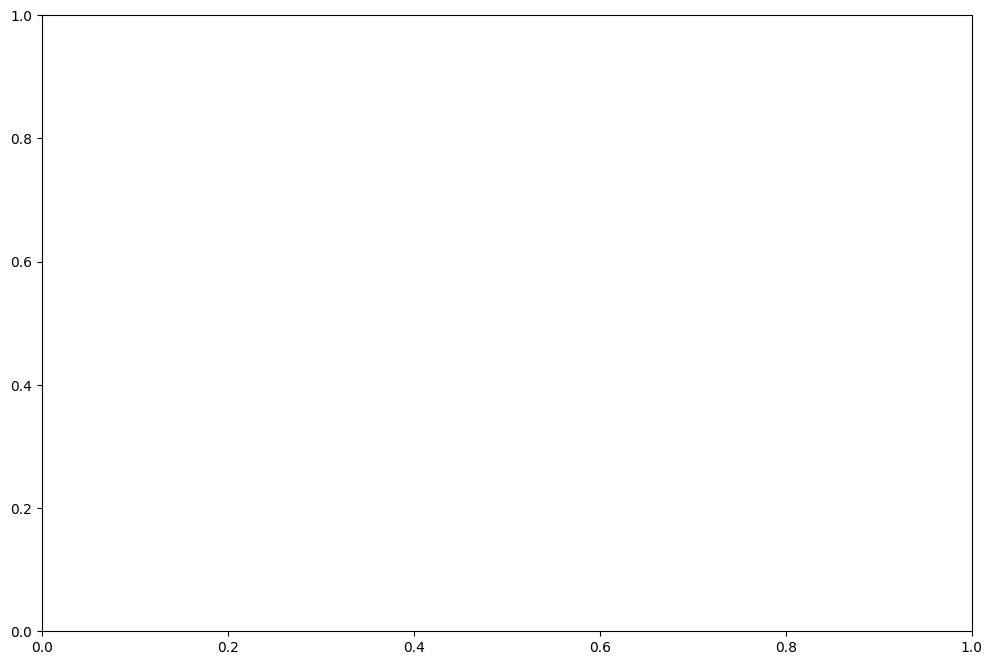

In [59]:
# # Create scatter plot
# plt.figure(figsize=(12, 8))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_cls, cmap='tab20', alpha=0.6)
# plt.colorbar()
# plt.title('t-SNE visualization of HDBSCAN clusters')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.show()